In [1]:
!pip install boto3
!pip install pandas
!pip install matplotlib
!pip install scipy
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.3 MB/s eta 0:00:00


In [2]:
import boto3
import pandas as pd
from io import StringIO
import time
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import os

# Set AWS credentials using environment variables
os.environ['AWS_ACCESS_KEY_ID'] = '...'  # Replace with your access key
os.environ['AWS_SECRET_ACCESS_KEY'] = '...'  # Replace with your secret key
os.environ['AWS_DEFAULT_REGION'] = '...'  # Replace with your region, e.g., 'us-east-1'

In [3]:
# Set up the S3 client
s3_client = boto3.client('s3')

# Define the bucket name and file key
bucket_name = 'beamdata-pocketride'
file_key = 'Chicago/chicago_data_10_perc_sample.csv'

# Step 1: Start the timer
start_time = time.time()

# Step 2: Read the CSV file from S3
response = s3_client.get_object(Bucket=bucket_name, Key=file_key)

# Check if the file was fetched successfully
if response.get("ResponseMetadata", {}).get("HTTPStatusCode") == 200:
    # Load the CSV content into a pandas DataFrame
    df = pd.read_csv(StringIO(response['Body'].read().decode('utf-8')))

    # Step 3: Stop the timer
    end_time = time.time()

    # Calculate the total time taken
    time_taken = end_time - start_time

    # Display the DataFrame and the time taken
    df.head()
    print(f"\nTime taken to read the file from S3: {time_taken:.2f} seconds")
else:
    print("Failed to fetch the file from S3.")


Time taken to read the file from S3: 184.07 seconds


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8683775 entries, 0 to 8683774
Data columns (total 36 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   trip_start_timestamp       object 
 2   trip_end_timestamp         object 
 3   trip_seconds               float64
 4   trip_miles                 float64
 5   percent_time_chicago       float64
 6   percent_distance_chicago   float64
 7   pickup_census_tract        float64
 8   dropoff_census_tract       float64
 9   pickup_community_area      float64
 10  dropoff_community_area     float64
 11  fare                       float64
 12  tip                        float64
 13  additional_charges         float64
 14  trip_total                 float64
 15  shared_trip_authorized     bool   
 16  shared_trip_match          bool   
 17  trips_pooled               int64  
 18  pickup_centroid_location   object 
 19  dropoff_centroid_location  object 
 20  Se

# Functions for z-score and IQR

In [5]:
def analyze_column(df, column_name, z_threshold=3, iqr_factor=1.5):
    from scipy import stats
    import numpy as np

    # Drop null values
    column_data = df[column_name].dropna()

    # Handle negative or zero values by applying a shift
    min_value = column_data.min()
    if min_value <= 0:
        shift = abs(min_value) + 1  # Add a constant to make all values positive
        column_data = column_data + shift
    else:
        shift = 0  # No shift needed

    # Calculate original skewness
    original_skewness = column_data.skew()

    # Apply log transformation
    column_data_log = np.log1p(column_data)  # Handles positive values safely

    # Calculate log skewness
    log_skewness = column_data_log.skew()

    # Calculate z-scores for log-transformed column
    z_scores_log = stats.zscore(column_data_log)

    # Calculate IQR for log-transformed column
    Q1 = column_data_log.quantile(0.25)
    Q3 = column_data_log.quantile(0.75)
    IQR = Q3 - Q1

    # Determine bounds for outliers
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    # Flag Z-score and IQR outliers
    z_outliers = np.abs(z_scores_log) > z_threshold
    iqr_outliers = (column_data_log < lower_bound) | (column_data_log > upper_bound)

    # Calculate confidence scores
    z_confidence = np.clip(np.abs(z_scores_log) / z_threshold, 0, 1)
    iqr_confidence = np.clip(
        np.where(column_data_log < lower_bound, (lower_bound - column_data_log) / IQR,
                 np.where(column_data_log > upper_bound, (column_data_log - upper_bound) / IQR, 0)),
        0, 1
    )

    # Combined confidence score
    combined_confidence = (z_confidence + iqr_confidence) / 2

    # Add new columns to the DataFrame
    df[f'IQR_{column_name}'] = iqr_outliers
    df[f'Z_OUTLIER_{column_name}'] = z_outliers
    df[f'CONFIDENCE_{column_name}'] = combined_confidence
    df[f'Z_LOG_SCORE_{column_name}'] = z_scores_log

    return original_skewness, log_skewness

def plot_histograms(df, column_name, original_skewness, log_skewness):
    column_data = df[column_name].dropna()
    column_data_log = np.log1p(column_data)

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=50, color='blue', alpha=0.7)
    plt.title(f'Original {column_name} Histogram')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(column_data_log, bins=50, color='green', alpha=0.7)
    plt.title(f'Log-transformed {column_name} Histogram')
    plt.xlabel(f'Log({column_name})')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print(f"Original Skewness of {column_name}: {original_skewness}")
    print(f"Log-transformed Skewness of {column_name}: {log_skewness}")



In [6]:
# Drop rows where both 'Distance (km)' and 'Trip Duration (min)' are null
df_cleaned = df.dropna(subset=['trip_miles', 'trip_seconds', 'fare'], how='all')

In [7]:
df_cleaned.shape

(8683775, 36)

# Trip Miles

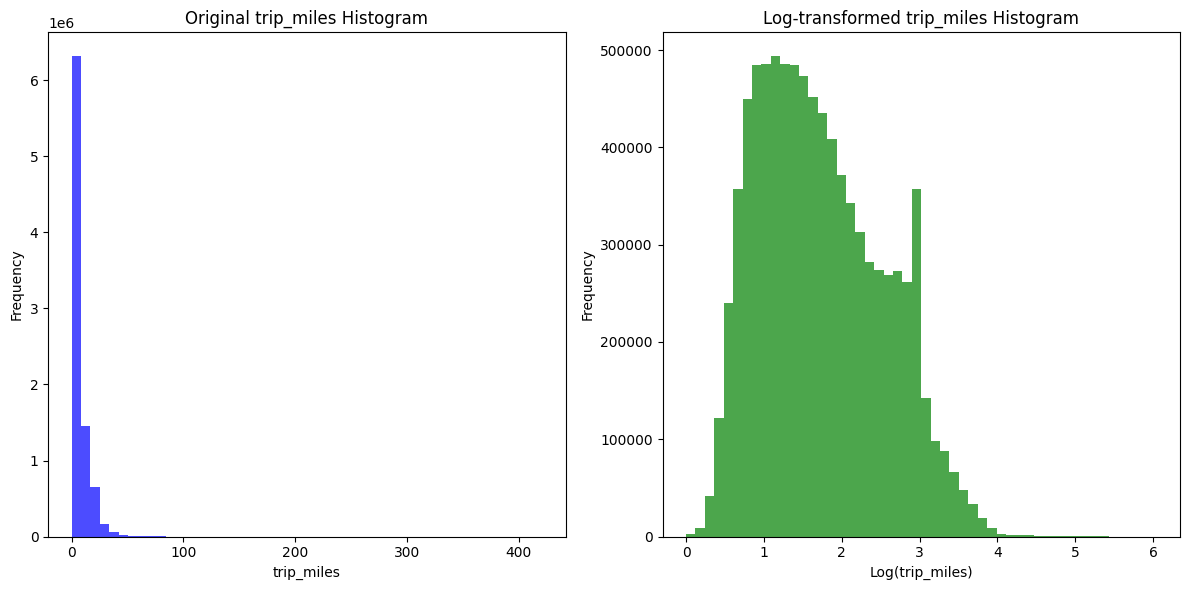

Original Skewness of trip_miles: 3.7905486749823827
Log-transformed Skewness of trip_miles: 0.4085137535300808


In [ ]:
# Example usage
# original_skewness, log_skewness = analyze_column(df, 'trip_miles')
# plot_histograms(df, 'trip_miles', original_skewness, log_skewness)
original_skewness, log_skewness = analyze_column(df_cleaned, 'trip_miles')
plot_histograms(df_cleaned, 'trip_miles', original_skewness, log_skewness)

# Trip seconds

In [ ]:
# df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
# df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

In [ ]:
# # Extract day of the week, day of the month, hour, and minute for trip_start_timestamp
# df['start_day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
# df['start_day_of_month'] = df['trip_start_timestamp'].dt.day
# df['start_hour'] = df['trip_start_timestamp'].dt.hour
# df['start_minute'] = df['trip_start_timestamp'].dt.minute

# # Extract day of the week, day of the month, hour, and minute for trip_end_timestamp
# df['end_day_of_week'] = df['trip_end_timestamp'].dt.dayofweek
# df['end_day_of_month'] = df['trip_end_timestamp'].dt.day
# df['end_hour'] = df['trip_end_timestamp'].dt.hour
# df['end_minute'] = df['trip_end_timestamp'].dt.minute

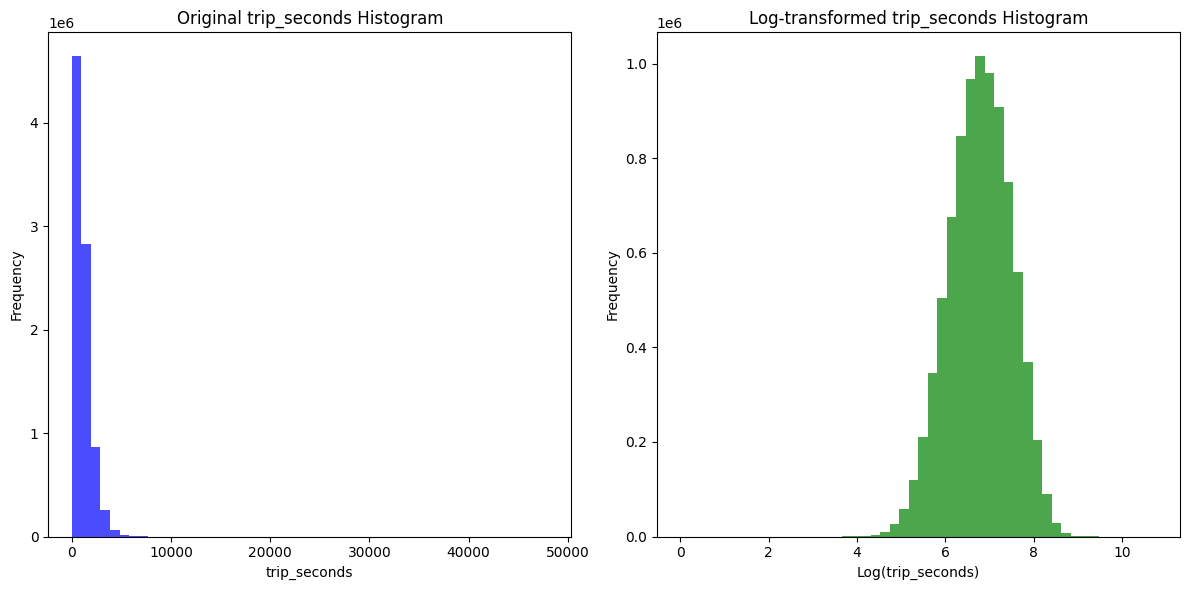

Original Skewness of trip_seconds: 1.973120500269839
Log-transformed Skewness of trip_seconds: -0.16350194122447562


In [ ]:
# Example usage
original_skewness, log_skewness = analyze_column(df_cleaned, 'trip_seconds')
plot_histograms(df_cleaned, 'trip_seconds', original_skewness, log_skewness)

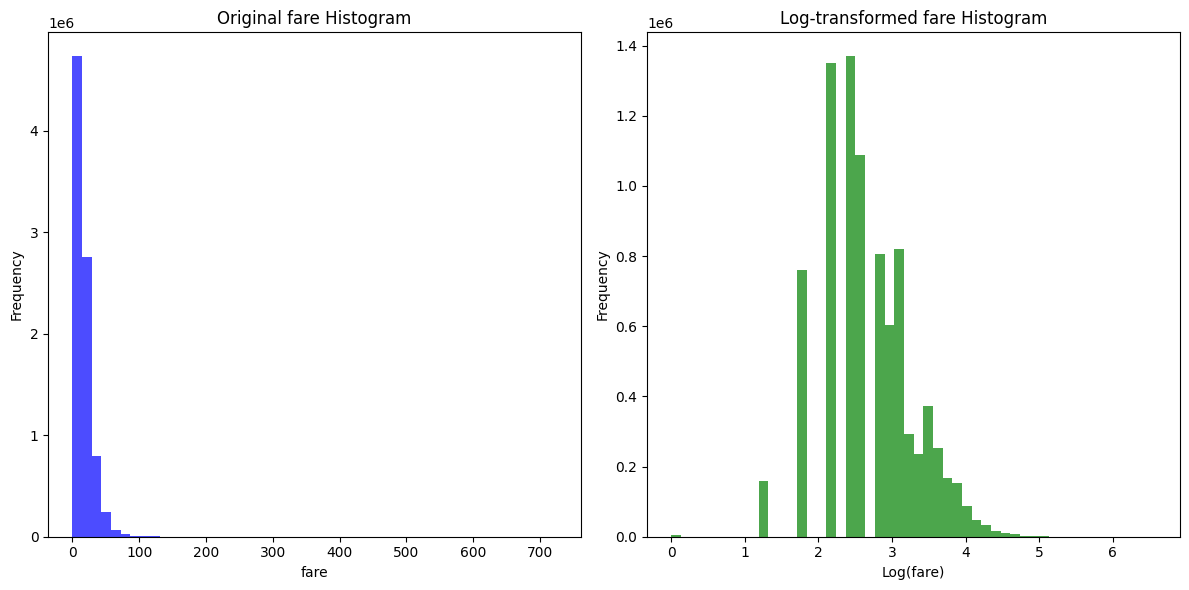

Original Skewness of fare: 3.1629896816472787
Log-transformed Skewness of fare: 0.25921004093340594


In [ ]:
# Example usage
original_skewness, log_skewness = analyze_column(df_cleaned, 'fare')
plot_histograms(df_cleaned, 'fare', original_skewness, log_skewness)

In [ ]:
df_cleaned.columns

Index(['Unnamed: 0', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'percent_time_chicago',
       'percent_distance_chicago', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tip', 'additional_charges',
       'trip_total', 'shared_trip_authorized', 'shared_trip_match',
       'trips_pooled', 'pickup_centroid_location', 'dropoff_centroid_location',
       'Serial_ID', 'weather_date', 'weather_hour', 'station_id', 'time',
       'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'coco', 'IQR_trip_miles', 'Z_OUTLIER_trip_miles',
       'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles', 'IQR_trip_seconds',
       'Z_OUTLIER_trip_seconds', 'CONFIDENCE_trip_seconds',
       'Z_LOG_SCORE_trip_seconds', 'IQR_fare', 'Z_OUTLIER_fare',
       'CONFIDENCE_fare', 'Z_LOG_SCORE_fare'],
      dtype='object')

In [ ]:
df_cleaned[['IQR_trip_miles', 'Z_OUTLIER_trip_miles',
       'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles',
       'IQR_trip_seconds', 'Z_OUTLIER_trip_seconds',
       'CONFIDENCE_trip_seconds', 'Z_LOG_SCORE_trip_seconds','IQR_fare', 'Z_OUTLIER_fare',
       'CONFIDENCE_fare', 'Z_LOG_SCORE_fare']].head()

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles,IQR_trip_seconds,Z_OUTLIER_trip_seconds,CONFIDENCE_trip_seconds,Z_LOG_SCORE_trip_seconds,IQR_fare,Z_OUTLIER_fare,CONFIDENCE_fare,Z_LOG_SCORE_fare
0,False,False,0.022268,-0.133609,False,False,0.001612,-0.009674,False,False,0.026055,0.156327
1,False,False,0.150184,0.901103,False,False,0.160463,0.962775,False,False,0.183879,1.103275
2,False,False,0.167188,-1.003130,False,False,0.076543,-0.459257,False,False,0.020392,-0.122352
3,False,False,0.021857,-0.131142,False,False,0.029671,-0.178029,False,False,0.076378,-0.458268
4,False,False,0.010661,-0.063966,False,False,0.131427,0.788562,False,False,0.131144,0.786863


In [ ]:
df_cleaned[['IQR_trip_miles', 'Z_OUTLIER_trip_miles',
       'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles']].head()

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
0,False,False,0.022268,-0.133609
1,False,False,0.150184,0.901103
2,False,False,0.167188,-1.003130
3,False,False,0.021857,-0.131142
4,False,False,0.010661,-0.063966


In [ ]:
trip_distance_metrics = df_cleaned[['IQR_trip_miles', 'Z_OUTLIER_trip_miles',
       'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles']]

In [ ]:
trip_distance_metrics.head()

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
0,False,False,0.022268,-0.133609
1,False,False,0.150184,0.901103
2,False,False,0.167188,-1.003130
3,False,False,0.021857,-0.131142
4,False,False,0.010661,-0.063966


In [ ]:
trip_distance_metrics.shape

(8683775, 4)

In [ ]:
trip_distance_metrics[trip_distance_metrics['CONFIDENCE_trip_miles'] < 0.5]

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
0,False,False,0.022268,-0.133609
1,False,False,0.150184,0.901103
2,False,False,0.167188,-1.003130
3,False,False,0.021857,-0.131142
4,False,False,0.010661,-0.063966
...,...,...,...,...
8683770,False,False,0.022021,-0.132128
8683771,False,False,0.051176,-0.307059
8683772,False,False,0.147460,0.884762
8683773,False,False,0.213226,-1.279354


In [ ]:
# Extract entries where either 'IQR_Distance (km)' or 'Z_OUTLIER_Distance (km)' is True
filtered_trip_distance_metrics = trip_distance_metrics[
    (trip_distance_metrics['IQR_trip_miles'] == True) |
    (trip_distance_metrics['Z_OUTLIER_trip_miles'] == True)
]

In [ ]:
filtered_trip_distance_metrics

,IQR_trip_miles,Z_OUTLIER_trip_miles,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles
6514,True,True,0.500127,3.075613
7064,True,True,0.679997,3.635459
8696,True,True,0.725321,3.776532
9126,True,True,0.909400,4.349477
9933,True,True,0.567626,3.285704
...,...,...,...,...
8678635,True,True,0.528817,3.164912
8680317,True,True,0.944950,4.460129
8680320,True,True,0.601688,3.391725
8680348,True,True,0.944950,4.460129


In [ ]:
trip_duration_metrics = df_cleaned[['IQR_trip_seconds', 'Z_OUTLIER_trip_seconds',
       'CONFIDENCE_trip_seconds', 'Z_LOG_SCORE_trip_seconds']]

In [ ]:
trip_duration_metrics.head()

,IQR_trip_seconds,Z_OUTLIER_trip_seconds,CONFIDENCE_trip_seconds,Z_LOG_SCORE_trip_seconds
0,False,False,0.001612,-0.009674
1,False,False,0.160463,0.962775
2,False,False,0.076543,-0.459257
3,False,False,0.029671,-0.178029
4,False,False,0.131427,0.788562


In [ ]:
trip_duration_metrics.shape

(8683775, 4)

In [ ]:
trip_duration_metrics[trip_duration_metrics['Z_OUTLIER_trip_seconds'] < 0.5]

,IQR_trip_seconds,Z_OUTLIER_trip_seconds,CONFIDENCE_trip_seconds,Z_LOG_SCORE_trip_seconds
0,False,False,0.001612,-0.009674
1,False,False,0.160463,0.962775
2,False,False,0.076543,-0.459257
3,False,False,0.029671,-0.178029
4,False,False,0.131427,0.788562
...,...,...,...,...
8683770,False,False,0.134495,0.806972
8683771,False,False,0.004783,0.028697
8683772,False,False,0.120365,0.722193
8683773,False,False,0.291076,-1.746455


In [ ]:
# Extract entries where either 'IQR_Distance (km)' or 'Z_OUTLIER_Distance (km)' is True
filtered_trip_duration_metrics = trip_duration_metrics[
    (trip_duration_metrics['IQR_trip_seconds'] == True) |
    (trip_duration_metrics['Z_OUTLIER_trip_seconds'] == True)
]

In [ ]:
filtered_trip_duration_metrics

,IQR_trip_seconds,Z_OUTLIER_trip_seconds,CONFIDENCE_trip_seconds,Z_LOG_SCORE_trip_seconds
13,True,True,0.630967,-3.144906
113,True,True,0.881539,-3.845341
369,True,True,0.754134,-3.489200
522,True,False,0.523487,2.916467
583,True,True,0.595731,-3.046409
...,...,...,...,...
8682590,True,True,0.974654,-4.105631
8683457,True,False,0.535359,-2.916534
8683524,True,True,0.703651,-3.348083
8683536,True,False,0.575476,-2.993033


In [ ]:
trip_duration_metrics[
    (trip_duration_metrics['Z_OUTLIER_trip_seconds'] == True)
]

,IQR_trip_seconds,Z_OUTLIER_trip_seconds,CONFIDENCE_trip_seconds,Z_LOG_SCORE_trip_seconds
13,True,True,0.630967,-3.144906
113,True,True,0.881539,-3.845341
369,True,True,0.754134,-3.489200
583,True,True,0.595731,-3.046409
827,True,True,0.715812,-3.382076
...,...,...,...,...
8681452,True,True,0.630967,-3.144906
8681586,True,True,0.675277,3.301857
8682187,True,True,0.668816,-3.250706
8682590,True,True,0.974654,-4.105631


In [ ]:
trip_fare_metrics = df_cleaned[['IQR_fare', 'Z_OUTLIER_fare',
       'CONFIDENCE_fare', 'Z_LOG_SCORE_fare']]

In [ ]:
trip_fare_metrics[trip_fare_metrics['CONFIDENCE_fare'] < 0.5]

,IQR_fare,Z_OUTLIER_fare,CONFIDENCE_fare,Z_LOG_SCORE_fare
0,False,False,0.026055,0.156327
1,False,False,0.183879,1.103275
2,False,False,0.020392,-0.122352
3,False,False,0.076378,-0.458268
4,False,False,0.131144,0.786863
...,...,...,...,...
8683770,False,False,0.076378,-0.458268
8683771,False,False,0.020392,-0.122352
8683772,False,False,0.299478,1.796871
8683773,False,False,0.242082,-1.452489


In [ ]:
# Extract entries where either 'IQR_Distance (km)' or 'Z_OUTLIER_Distance (km)' is True
filtered_trip_fare_metrics = trip_fare_metrics[
    (trip_fare_metrics['IQR_fare'] == True) |
    (trip_fare_metrics['Z_OUTLIER_fare'] == True)
]

In [ ]:
filtered_trip_fare_metrics.head()

,IQR_fare,Z_OUTLIER_fare,CONFIDENCE_fare,Z_LOG_SCORE_fare
382,True,False,0.515185,2.914850
522,True,True,0.751379,3.573549
590,True,False,0.490812,2.866462
823,True,True,0.694804,3.405687
835,True,False,0.515185,2.914850


## Drop off zone Counts Outlier Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8683775 entries, 0 to 8683774
Data columns (total 36 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   trip_start_timestamp       object 
 2   trip_end_timestamp         object 
 3   trip_seconds               float64
 4   trip_miles                 float64
 5   percent_time_chicago       float64
 6   percent_distance_chicago   float64
 7   pickup_census_tract        float64
 8   dropoff_census_tract       float64
 9   pickup_community_area      float64
 10  dropoff_community_area     float64
 11  fare                       float64
 12  tip                        float64
 13  additional_charges         float64
 14  trip_total                 float64
 15  shared_trip_authorized     bool   
 16  shared_trip_match          bool   
 17  trips_pooled               int64  
 18  pickup_centroid_location   object 
 19  dropoff_centroid_location  object 
 20  Se

In [10]:
df = df.dropna(subset = ['dropoff_centroid_location', 'pickup_centroid_location'])

In [11]:
df['dropoff_longitude'] = df['dropoff_centroid_location'].str.extract(r'POINT \(([-\d.]+)')  # Extracts longitude
df['dropoff_latitude'] = df['dropoff_centroid_location'].str.extract(r'POINT \([-\d.]+ ([-\d.]+)\)')  # Extracts latitude

# Convert the extracted columns to float for numerical operations
df['dropoff_longitude'] = df['dropoff_longitude'].astype(float)
df['dropoff_latitude'] = df['dropoff_latitude'].astype(float)

<ipython-input-11-30e19f0864c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dropoff_longitude'] = df['dropoff_centroid_location'].str.extract(r'POINT \(([-\d.]+)')  # Extracts longitude
<ipython-input-11-30e19f0864c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dropoff_latitude'] = df['dropoff_centroid_location'].str.extract(r'POINT \([-\d.]+ ([-\d.]+)\)')  # Extracts latitude
<ipython-input-11-30e19f0864c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [12]:
from shapely.geometry import Polygon, Point

# Get the boundary of the data (min and max lat/lon)
min_lat, max_lat = df['dropoff_latitude'].min(), df['dropoff_latitude'].max()
min_lon, max_lon = df['dropoff_longitude'].min(), df['dropoff_longitude'].max()

# Create a boundary rectangle as a Polygon
boundary_polygon = Polygon([
    (min_lon, min_lat),
    (min_lon, max_lat),
    (max_lon, max_lat),
    (max_lon, min_lat),
    (min_lon, min_lat)
])

# Partition the boundary rectangle into a 10x10 grid
grid_size_x = (max_lon - min_lon) / 10  # Width of each grid cell
grid_size_y = (max_lat - min_lat) / 10  # Height of each grid cell

# Create grid cells as polygons
polygons = []
for i in range(10):
    for j in range(10):
        x_start = min_lon + i * grid_size_x
        y_start = min_lat + j * grid_size_y
        x_end = x_start + grid_size_x
        y_end = y_start + grid_size_y
        polygons.append(Polygon([(x_start, y_start), (x_start, y_end), (x_end, y_end), (x_end, y_start), (x_start, y_start)]))


KeyError: 'dropoff_latitude'

In [13]:
def allocate_zone(lat, lon):
    # Calculate the row and column based on lat/lon position in the grid
    col = int((lon - min_lon) // grid_size_x)
    row = int((lat - min_lat) // grid_size_y)
    # Ensure col and row do not exceed 14 (the maximum index for a 15x15 grid)
    col = min(max(col, 0), 9)
    row = min(max(row, 0), 9)
    # Zone number calculation (row-major order)
    zone_number = row * 10 + col + 1  # +1 to start numbering from 1
    return zone_number

# Apply the function to create the 'zone' column
df['zone'] = df.apply(lambda row: allocate_zone(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)


<ipython-input-13-1905532f5bf9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zone'] = df.apply(lambda row: allocate_zone(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)


In [14]:
df.head()

,Unnamed: 0,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,pickup_census_tract,dropoff_census_tract,pickup_community_area,...,snow,wdir,wspd,wpgt,pres,tsun,coco,dropoff_longitude,dropoff_latitude,zone
0,0,2023-05-13T22:45:00.000,2023-05-13T23:00:00.000,880.0,4.08,1.0000,1.0000,NaN,NaN,43.0,...,NaN,50.0,18.4,NaN,1021.0,NaN,4.0,-87.592311,41.794090,39
1,1,2023-05-07T00:15:00.000,2023-05-07T00:45:00.000,1740.0,10.59,1.0000,1.0000,1.703168e+10,1.703149e+10,68.0,...,NaN,170.0,18.4,NaN,1012.5,NaN,3.0,-87.628357,41.717964,18
2,2,2023-05-11T20:15:00.000,2023-05-11T20:30:00.000,642.0,1.54,0.9985,1.0000,1.703133e+10,1.703132e+10,33.0,...,NaN,130.0,16.6,NaN,1016.0,NaN,3.0,-87.620993,41.884987,68
3,3,2023-05-09T20:15:00.000,2023-05-09T20:30:00.000,782.0,4.09,1.0000,1.0000,NaN,NaN,24.0,...,NaN,30.0,14.8,NaN,1021.5,NaN,3.0,-87.723452,41.953582,85
4,4,2023-05-20T12:45:00.000,2023-05-20T13:15:00.000,1540.0,4.37,0.9995,0.9995,1.703107e+10,1.703184e+10,7.0,...,NaN,320.0,13.0,NaN,1021.0,NaN,2.0,-87.690775,41.944814,76


In [15]:
df['trip_count'] = 1

<ipython-input-15-a978621ac882>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_count'] = 1


In [16]:
df.head()

,Unnamed: 0,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,pickup_census_tract,dropoff_census_tract,pickup_community_area,...,wdir,wspd,wpgt,pres,tsun,coco,dropoff_longitude,dropoff_latitude,zone,trip_count
0,0,2023-05-13T22:45:00.000,2023-05-13T23:00:00.000,880.0,4.08,1.0000,1.0000,NaN,NaN,43.0,...,50.0,18.4,NaN,1021.0,NaN,4.0,-87.592311,41.794090,39,1
1,1,2023-05-07T00:15:00.000,2023-05-07T00:45:00.000,1740.0,10.59,1.0000,1.0000,1.703168e+10,1.703149e+10,68.0,...,170.0,18.4,NaN,1012.5,NaN,3.0,-87.628357,41.717964,18,1
2,2,2023-05-11T20:15:00.000,2023-05-11T20:30:00.000,642.0,1.54,0.9985,1.0000,1.703133e+10,1.703132e+10,33.0,...,130.0,16.6,NaN,1016.0,NaN,3.0,-87.620993,41.884987,68,1
3,3,2023-05-09T20:15:00.000,2023-05-09T20:30:00.000,782.0,4.09,1.0000,1.0000,NaN,NaN,24.0,...,30.0,14.8,NaN,1021.5,NaN,3.0,-87.723452,41.953582,85,1
4,4,2023-05-20T12:45:00.000,2023-05-20T13:15:00.000,1540.0,4.37,0.9995,0.9995,1.703107e+10,1.703184e+10,7.0,...,320.0,13.0,NaN,1021.0,NaN,2.0,-87.690775,41.944814,76,1


In [17]:
## Create month, day of week, year, hour, and date columns

df['month'] = pd.to_datetime(df['trip_start_timestamp']).dt.month
df['dayofweek'] = pd.to_datetime(df['trip_start_timestamp']).dt.dayofweek
df['year'] = pd.to_datetime(df['trip_start_timestamp']).dt.year
df['hour'] = pd.to_datetime(df['trip_start_timestamp']).dt.hour
df['date'] = pd.to_datetime(df['trip_start_timestamp']).dt.day

<ipython-input-17-2a4c54fcf53b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['trip_start_timestamp']).dt.month
<ipython-input-17-2a4c54fcf53b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = pd.to_datetime(df['trip_start_timestamp']).dt.dayofweek
<ipython-input-17-2a4c54fcf53b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [18]:
df.head()

,Unnamed: 0,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,pickup_census_tract,dropoff_census_tract,pickup_community_area,...,coco,dropoff_longitude,dropoff_latitude,zone,trip_count,month,dayofweek,year,hour,date
0,0,2023-05-13T22:45:00.000,2023-05-13T23:00:00.000,880.0,4.08,1.0000,1.0000,NaN,NaN,43.0,...,4.0,-87.592311,41.794090,39,1,5,5,2023,22,13
1,1,2023-05-07T00:15:00.000,2023-05-07T00:45:00.000,1740.0,10.59,1.0000,1.0000,1.703168e+10,1.703149e+10,68.0,...,3.0,-87.628357,41.717964,18,1,5,6,2023,0,7
2,2,2023-05-11T20:15:00.000,2023-05-11T20:30:00.000,642.0,1.54,0.9985,1.0000,1.703133e+10,1.703132e+10,33.0,...,3.0,-87.620993,41.884987,68,1,5,3,2023,20,11
3,3,2023-05-09T20:15:00.000,2023-05-09T20:30:00.000,782.0,4.09,1.0000,1.0000,NaN,NaN,24.0,...,3.0,-87.723452,41.953582,85,1,5,1,2023,20,9
4,4,2023-05-20T12:45:00.000,2023-05-20T13:15:00.000,1540.0,4.37,0.9995,0.9995,1.703107e+10,1.703184e+10,7.0,...,2.0,-87.690775,41.944814,76,1,5,5,2023,12,20


In [20]:
filtered_df = df.drop(['trip_start_timestamp','percent_time_chicago','percent_distance_chicago',
                                 'pickup_centroid_location','dropoff_centroid_location'],axis=1)

In [21]:
df_aggregated = filtered_df.groupby(['zone','month','date', 'year', 'hour']).agg(sum).reset_index()

<ipython-input-21-39650d031478>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_aggregated = filtered_df.groupby(['zone','month','date', 'year', 'hour']).agg(sum).reset_index()


In [22]:
df_aggregated.head()

,zone,month,date,year,hour,Unnamed: 0,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,...,wdir,wspd,wpgt,pres,tsun,coco,dropoff_longitude,dropoff_latitude,trip_count,dayofweek
0,6,1,1,2024,1,5872343,2024-01-01T01:45:00.000,184.0,0.796,1.703174e+10,...,320.0,24.1,0.0,1018.5,0.0,3.0,-87.719313,41.687239,1,0
1,6,1,1,2024,2,5802693,2024-01-01T02:00:00.000,231.0,1.069,1.703182e+10,...,330.0,25.9,0.0,1019.0,0.0,3.0,-87.719313,41.687239,1,0
2,6,1,3,2024,12,6258658,2024-01-03T12:30:00.000,657.0,3.670,1.703175e+10,...,280.0,5.4,0.0,1018.0,0.0,3.0,-87.719313,41.687239,1,2
3,6,1,5,2024,20,6068276,2024-01-05T21:00:00.000,1201.0,7.484,1.703150e+10,...,190.0,11.2,0.0,1022.0,0.0,3.0,-87.719313,41.687239,1,4
4,6,1,6,2024,2,6100252,2024-01-06T02:00:00.000,597.0,1.530,1.703175e+10,...,140.0,13.0,0.0,1018.0,0.0,3.0,-87.719313,41.687239,1,5


In [24]:
df_aggregated['trip_count'].min(), df_aggregated['trip_count'].max()

(1, 748)

In [27]:
# Example usage
original_skewness, log_skewness = analyze_column(df_aggregated, 'trip_count')


In [28]:
df_aggregated.columns

Index(['zone', 'month', 'date', 'year', 'hour', 'Unnamed: 0',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tip', 'additional_charges',
       'trip_total', 'shared_trip_authorized', 'shared_trip_match',
       'trips_pooled', 'Serial_ID', 'weather_date', 'weather_hour',
       'station_id', 'time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir',
       'wspd', 'wpgt', 'pres', 'tsun', 'coco', 'dropoff_longitude',
       'dropoff_latitude', 'trip_count', 'dayofweek', 'IQR_trip_count',
       'Z_OUTLIER_trip_count', 'CONFIDENCE_trip_count',
       'Z_LOG_SCORE_trip_count'],
      dtype='object')

In [30]:
trip_count_metrics = df_aggregated[['zone', 'IQR_trip_count', 'Z_OUTLIER_trip_count',
       'CONFIDENCE_trip_count', 'Z_LOG_SCORE_trip_count']]

In [31]:
trip_count_metrics.head()

,zone,IQR_trip_count,Z_OUTLIER_trip_count,CONFIDENCE_trip_count,Z_LOG_SCORE_trip_count
0,6,False,False,0.227866,-1.367199
1,6,False,False,0.227866,-1.367199
2,6,False,False,0.227866,-1.367199
3,6,False,False,0.227866,-1.367199
4,6,False,False,0.227866,-1.367199


In [32]:
trip_count_metrics[trip_count_metrics['Z_OUTLIER_trip_count'] < 0.5]

,zone,IQR_trip_count,Z_OUTLIER_trip_count,CONFIDENCE_trip_count,Z_LOG_SCORE_trip_count
0,6,False,False,0.227866,-1.367199
1,6,False,False,0.227866,-1.367199
2,6,False,False,0.227866,-1.367199
3,6,False,False,0.227866,-1.367199
4,6,False,False,0.227866,-1.367199
...,...,...,...,...,...
405977,97,False,False,0.209651,1.257907
405978,97,False,False,0.256258,1.537547
405979,97,False,False,0.259088,1.554529
405980,97,False,False,0.234774,1.408646


In [34]:
# Extract entries where either 'IQR_Inflow_Count' or 'Z_OUTLIER_Inflow_Count' is True
filtered_trip_count_metrics = trip_count_metrics[
    (trip_count_metrics['IQR_trip_count'] == True) |
    (trip_count_metrics['Z_OUTLIER_trip_count'] == True)
]

In [36]:
filtered_trip_count_metrics

,zone,IQR_trip_count,Z_OUTLIER_trip_count,CONFIDENCE_trip_count,Z_LOG_SCORE_trip_count
203204,56,True,False,0.439906,2.614368
215029,58,True,False,0.554921,2.827543
215030,58,True,False,0.469393,2.669020
215053,58,True,False,0.569921,2.855344
217536,58,True,False,0.586510,2.886090
...,...,...,...,...,...
361558,87,True,False,0.461528,2.654444
361561,87,True,False,0.489756,2.706763
363087,87,True,False,0.502059,2.729566
363088,87,True,False,0.561407,2.839564


In [37]:
df.shape

(7910282, 45)

# Create an new Data with Outlier Information



In [8]:
original_skewness, log_skewness = analyze_column(df_cleaned, 'trip_miles')
original_skewness, log_skewness = analyze_column(df_cleaned, 'trip_seconds')
original_skewness, log_skewness = analyze_column(df_cleaned, 'fare')

In [9]:
df_cleaned.head()

,Unnamed: 0,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,pickup_census_tract,dropoff_census_tract,pickup_community_area,...,CONFIDENCE_trip_miles,Z_LOG_SCORE_trip_miles,IQR_trip_seconds,Z_OUTLIER_trip_seconds,CONFIDENCE_trip_seconds,Z_LOG_SCORE_trip_seconds,IQR_fare,Z_OUTLIER_fare,CONFIDENCE_fare,Z_LOG_SCORE_fare
0,0,2023-05-13T22:45:00.000,2023-05-13T23:00:00.000,880.0,4.08,1.0000,1.0000,NaN,NaN,43.0,...,0.031528,-0.189165,False,False,0.001691,-0.010148,False,False,0.022940,0.137640
1,1,2023-05-07T00:15:00.000,2023-05-07T00:45:00.000,1740.0,10.59,1.0000,1.0000,1.703168e+10,1.703149e+10,68.0,...,0.147086,0.882514,False,False,0.160507,0.963040,False,False,0.184812,1.108873
2,2,2023-05-11T20:15:00.000,2023-05-11T20:30:00.000,642.0,1.54,0.9985,1.0000,1.703133e+10,1.703132e+10,33.0,...,0.164249,-0.985496,False,False,0.076641,-0.459843,False,False,0.023775,-0.142649
3,3,2023-05-09T20:15:00.000,2023-05-09T20:30:00.000,782.0,4.09,1.0000,1.0000,NaN,NaN,24.0,...,0.031124,-0.186746,False,False,0.029761,-0.178567,False,False,0.079352,-0.476113
4,4,2023-05-20T12:45:00.000,2023-05-20T13:15:00.000,1540.0,4.37,0.9995,0.9995,1.703107e+10,1.703184e+10,7.0,...,0.020094,-0.120564,False,False,0.131443,0.788658,False,False,0.130270,0.781619


In [10]:
df_cleaned = df_cleaned.dropna(subset = ['dropoff_centroid_location', 'pickup_centroid_location'])

In [11]:
df_cleaned['dropoff_longitude'] = df_cleaned['dropoff_centroid_location'].str.extract(r'POINT \(([-\d.]+)')  # Extracts longitude
df_cleaned['dropoff_latitude'] = df_cleaned['dropoff_centroid_location'].str.extract(r'POINT \([-\d.]+ ([-\d.]+)\)')  # Extracts latitude

# Convert the extracted columns to float for numerical operations
df_cleaned['dropoff_longitude'] = df_cleaned['dropoff_longitude'].astype(float)
df_cleaned['dropoff_latitude'] = df_cleaned['dropoff_latitude'].astype(float)

In [13]:
from shapely.geometry import Polygon, Point

# Get the boundary of the data (min and max lat/lon)
min_lat, max_lat = df_cleaned['dropoff_latitude'].min(), df_cleaned['dropoff_latitude'].max()
min_lon, max_lon = df_cleaned['dropoff_longitude'].min(), df_cleaned['dropoff_longitude'].max()

# Create a boundary rectangle as a Polygon
boundary_polygon = Polygon([
    (min_lon, min_lat),
    (min_lon, max_lat),
    (max_lon, max_lat),
    (max_lon, min_lat),
    (min_lon, min_lat)
])

# Partition the boundary rectangle into a 10x10 grid
grid_size_x = (max_lon - min_lon) / 10  # Width of each grid cell
grid_size_y = (max_lat - min_lat) / 10  # Height of each grid cell

# Create grid cells as polygons
polygons = []
for i in range(10):
    for j in range(10):
        x_start = min_lon + i * grid_size_x
        y_start = min_lat + j * grid_size_y
        x_end = x_start + grid_size_x
        y_end = y_start + grid_size_y
        polygons.append(Polygon([(x_start, y_start), (x_start, y_end), (x_end, y_end), (x_end, y_start), (x_start, y_start)]))


In [14]:
def allocate_zone(lat, lon):
    # Calculate the row and column based on lat/lon position in the grid
    col = int((lon - min_lon) // grid_size_x)
    row = int((lat - min_lat) // grid_size_y)
    # Ensure col and row do not exceed 14 (the maximum index for a 15x15 grid)
    col = min(max(col, 0), 9)
    row = min(max(row, 0), 9)
    # Zone number calculation (row-major order)
    zone_number = row * 10 + col + 1  # +1 to start numbering from 1
    return zone_number

# Apply the function to create the 'zone' column
df_cleaned['zone'] = df_cleaned.apply(lambda row: allocate_zone(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)


In [15]:
df_cleaned['trip_count'] = 1

In [16]:
## Create month, day of week, year, hour, and date columns

df_cleaned['month'] = pd.to_datetime(df_cleaned['trip_start_timestamp']).dt.month
df_cleaned['dayofweek'] = pd.to_datetime(df_cleaned['trip_start_timestamp']).dt.dayofweek
df_cleaned['year'] = pd.to_datetime(df_cleaned['trip_start_timestamp']).dt.year
df_cleaned['hour'] = pd.to_datetime(df_cleaned['trip_start_timestamp']).dt.hour
df_cleaned['date'] = pd.to_datetime(df_cleaned['trip_start_timestamp']).dt.day

In [22]:
df_cleaned.shape

(7176900, 57)

In [24]:
# Save the DataFrame as a CSV file in memory
csv_buffer = StringIO()
df_cleaned.to_csv(csv_buffer, index=False)

# Initialize the S3 client
s3 = boto3.client('s3')

# Specify bucket details
bucket_name = "beamdata-pocketride"
s3_key = "Outlier_data/Chicago/10_percent_chicago_data_with_z_score.csv"  # Change the filename as desired

# Upload the CSV file to S3
s3.put_object(Bucket=bucket_name, Key=s3_key, Body=csv_buffer.getvalue())

print(f"File successfully uploaded to s3://{bucket_name}/{s3_key}")

File successfully uploaded to s3://beamdata-pocketride/Outlier_data/Chicago/10_percent_chicago_data_with_z_score.csv


In [17]:
filtered_df = df_cleaned.drop(['trip_start_timestamp','percent_time_chicago','percent_distance_chicago',
                                 'pickup_centroid_location','dropoff_centroid_location'],axis=1)

In [18]:
df_aggregated = filtered_df.groupby(['zone','month','date', 'year', 'hour']).agg(sum).reset_index()

<ipython-input-18-39650d031478>:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_aggregated = filtered_df.groupby(['zone','month','date', 'year', 'hour']).agg(sum).reset_index()


In [19]:
# Example usage
original_skewness, log_skewness = analyze_column(df_aggregated, 'trip_count')


In [20]:
df_aggregated.columns

Index(['zone', 'month', 'date', 'year', 'hour', 'Unnamed: 0',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tip', 'additional_charges',
       'trip_total', 'shared_trip_authorized', 'shared_trip_match',
       'trips_pooled', 'Serial_ID', 'weather_date', 'weather_hour',
       'station_id', 'time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir',
       'wspd', 'wpgt', 'pres', 'tsun', 'coco', 'IQR_trip_miles',
       'Z_OUTLIER_trip_miles', 'CONFIDENCE_trip_miles',
       'Z_LOG_SCORE_trip_miles', 'IQR_trip_seconds', 'Z_OUTLIER_trip_seconds',
       'CONFIDENCE_trip_seconds', 'Z_LOG_SCORE_trip_seconds', 'IQR_fare',
       'Z_OUTLIER_fare', 'CONFIDENCE_fare', 'Z_LOG_SCORE_fare',
       'dropoff_longitude', 'dropoff_latitude', 'trip_count', 'dayofweek',
       'IQR_trip_count', 'Z_OUTLIER_trip_count', 'CONFIDENCE_trip_count',
       'Z_LOG_SCORE_trip_count

In [21]:
df_aggregated.shape

(393947, 56)

In [25]:
columns_to_remove = [
    'IQR_trip_miles', 'Z_OUTLIER_trip_miles', 'CONFIDENCE_trip_miles', 'Z_LOG_SCORE_trip_miles',
    'IQR_trip_seconds', 'Z_OUTLIER_trip_seconds', 'CONFIDENCE_trip_seconds', 'Z_LOG_SCORE_trip_seconds',
    'IQR_fare', 'Z_OUTLIER_fare', 'CONFIDENCE_fare', 'Z_LOG_SCORE_fare'
]

# Drop the specified columns
df_aggregated = df_aggregated.drop(columns=columns_to_remove)

# Verify the columns are removed
print(df_aggregated.columns)


Index(['zone', 'month', 'date', 'year', 'hour', 'Unnamed: 0',
       'trip_end_timestamp', 'trip_seconds', 'trip_miles',
       'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tip', 'additional_charges',
       'trip_total', 'shared_trip_authorized', 'shared_trip_match',
       'trips_pooled', 'Serial_ID', 'weather_date', 'weather_hour',
       'station_id', 'time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir',
       'wspd', 'wpgt', 'pres', 'tsun', 'coco', 'dropoff_longitude',
       'dropoff_latitude', 'trip_count', 'dayofweek', 'IQR_trip_count',
       'Z_OUTLIER_trip_count', 'CONFIDENCE_trip_count',
       'Z_LOG_SCORE_trip_count'],
      dtype='object')


In [26]:
df_aggregated.shape

(393947, 44)

In [27]:
# Save the DataFrame as a CSV file in memory
csv_buffer = StringIO()
df_aggregated.to_csv(csv_buffer, index=False)

# Initialize the S3 client
s3 = boto3.client('s3')

# Specify bucket details
bucket_name = "beamdata-pocketride"
s3_key = "Outlier_data/Chicago/10_percent_chicago_data_with_trip_count_z_score.csv"  # Change the filename as desired

# Upload the CSV file to S3
s3.put_object(Bucket=bucket_name, Key=s3_key, Body=csv_buffer.getvalue())

print(f"File successfully uploaded to s3://{bucket_name}/{s3_key}")

File successfully uploaded to s3://beamdata-pocketride/Outlier_data/Chicago/10_percent_chicago_data_with_trip_count_z_score.csv
